In [1]:
from torch.utils.data import Dataset
import torch
# make autoreload
from IPython import get_ipython
import numpy as np
ipython = get_ipython()
ipython.magic('load_ext autoreload')

class PolyDataset(Dataset):
    def __init__(self, degree: int, num_points: int, num_functions: int, num_samples: int = 1):
        self.degree = degree # max degree of each sampled polynomial
        self.num_points = num_points # nr of points to sample from each polynomial as the context length
        self.num_functions = num_functions # nr of plolynomials to use, these will be random at each new step
        # self.num_samples = num_samples # nr of samples to generate for each function
        self.x = torch.linspace(0, 1, num_points)

    def __len__(self):
        return self.num_functions * self.num_points

    def __getitem__(self, idx: int ):
        # for beginning since there is a ton of polynomials to sample from we will just sample a random one
        # need to make sure that numerical evals stay within range of of float32
        # sample random polynomial of degree k
        # sample random points from the polynomial

        # y = a_n * x^n + a_n-1 * x^n-1 + ... + a_0

        # sample k roots
        roots = torch.rand(self.degree) 

        # numpy get random polynomial
        y = self._polynomial(roots, self.x)
        return torch.tensor(y).reshape(-1)
    
    def _polynomial(self, roots, x):
        coeff = np.poly(roots)
        return np.polyval(coeff, x)


/tmp/ipykernel_163636/3791145972.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic('load_ext autoreload')


In [16]:
np.poly(torch.rand(10))

array([ 1.0000000e+00, -4.6548452e+00,  9.3037348e+00, -1.0479361e+01,
        7.3408518e+00, -3.3264210e+00,  9.7957343e-01, -1.8219131e-01,
        1.9774027e-02, -1.0259694e-03,  1.1602624e-05], dtype=float32)

In [8]:
torch.linspace(0, 1, 6)[None,:]

tensor([[0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000]])

In [9]:
from model.hippo import HiPPO_LegT

model = HiPPO_LegT(10,dt=0.1)

In [10]:
ds = PolyDataset(15, 10, 1)
dl = torch.utils.data.DataLoader(ds, batch_size=3, shuffle=True)

In [11]:
for i, y in enumerate(dl):
    model.forward_batched(y)
    break

torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([10, 10]) torch.Size([10]) torch.Size([10]) torch.Size([1])


RuntimeError: 1D tensors expected, but got 2D and 1D tensors

In [12]:
import torch
from icl_learning.data import PolyDataset, WhiteSignalDataset, get_datasets
from model.hippo import HiPPO_LegT
import yaml
import torch
from torch.utils.data import DataLoader
from icl_learning.optimizer import select_optim
import wandb
from matplotlib import pyplot as plt
from icl_learning.config import load_configs
import random
import numpy as np
from icl_learning.train import load_checkpoint

config = load_configs()
dataset = get_datasets(config=config, test=False)
dataset_test = get_datasets(config=config, test=True)
dataloader_test = DataLoader(dataset_test, batch_size=config["train"]["batch_size"], shuffle=False)
dataloader = DataLoader(dataset, batch_size=config["train"]["batch_size"], shuffle=False)

model = HiPPO_LegT(N=config["model"]["rank"], dt=1/config["train"]["data"]["num_points"], teacher_ratio=config["train"]["teacher_ratio"], trainable=True)
model_test = HiPPO_LegT(N=config["model"]["rank"], dt=1/config["train"]["data"]["num_points"], teacher_ratio=config["train"]["teacher_ratio"], trainable=False)

opt=select_optim(config, model)
load_checkpoint(config, model, opt=opt)

/home/kilian/In-Context-SSM/icl_learning/data.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sine).to(torch.float32).to(self.device)


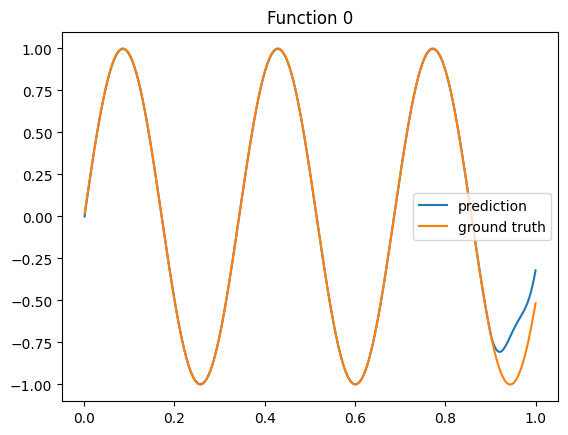

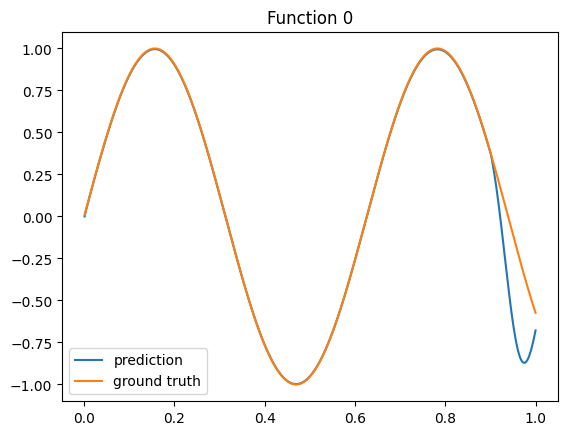

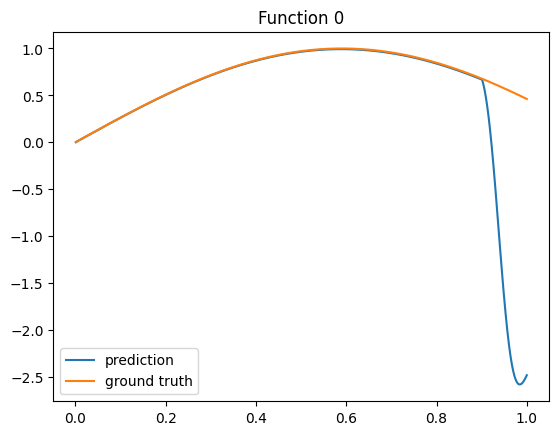

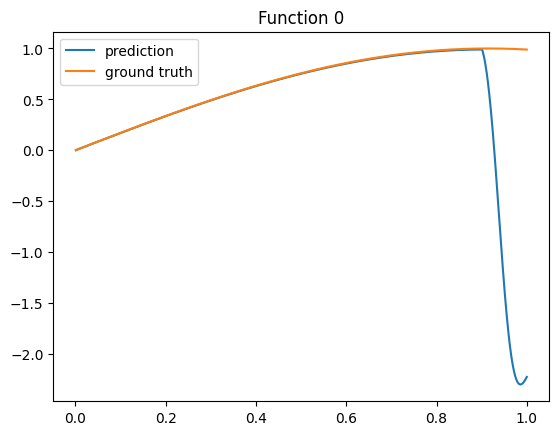

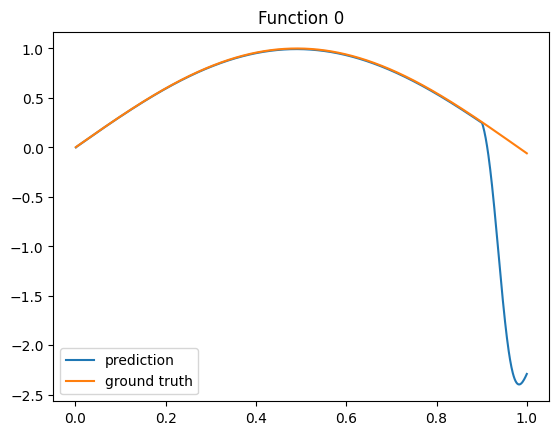

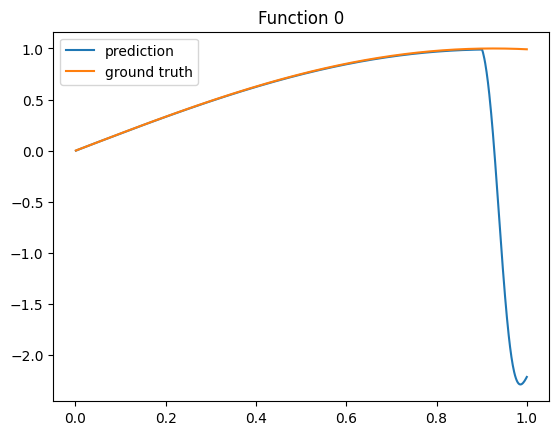

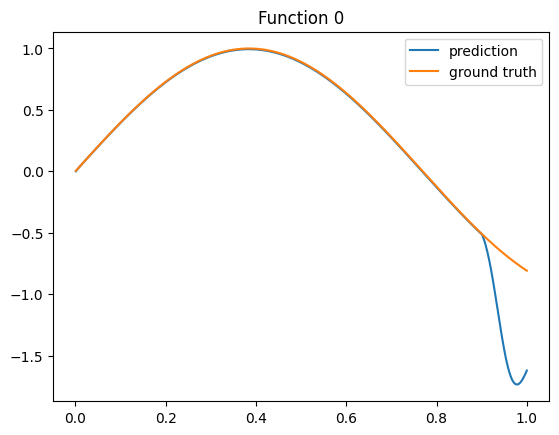

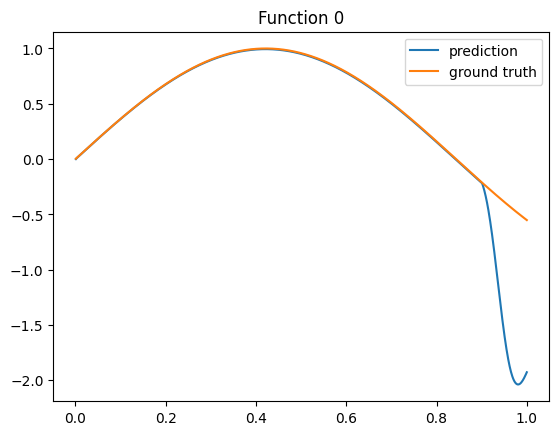

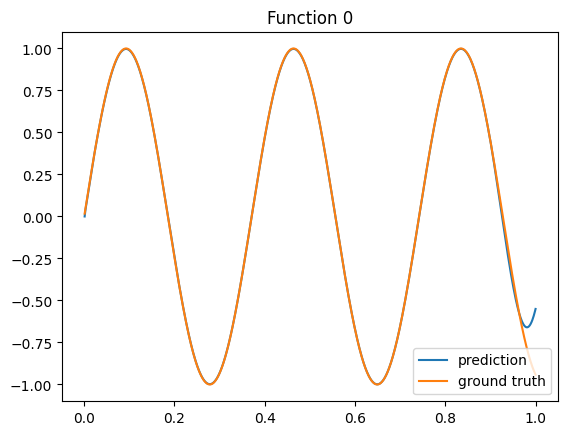

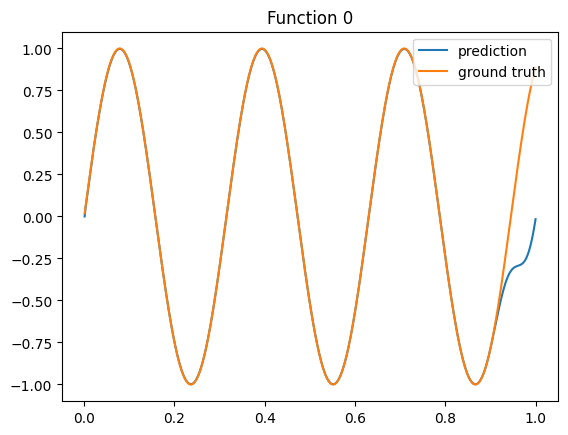

In [15]:

from icl_learning.train import autoregressive

@autoregressive
def test(config, dataloader, model, test=True, start=0, end = 1000):
    model.eval()
    x = dataloader.dataset.x
    with torch.no_grad():
        total_loss = 0
        for i, y in enumerate(dataloader):
            y_hat = model(y) # Now y is the signal 1,2,3,4,5,N+1, and y is 0,1,2,3,4,5..., N
            loss = torch.nn.MSELoss()(y_hat[:,:-1], y[:,1:])
            total_loss += loss.item()
            # make plots of the predictions and the ground truth and log them to wandb
            if i==0:
                for j in range(config["test"]["num_plots"]):
                    plt.figure()
                    plt.plot(x[start+1:end], y_hat[j][start:end-1].numpy(), label="prediction")
                    plt.plot(x[start+1:end], y[j][start+1:end].numpy(), label="ground truth")
                    plt.legend()
                    plt.title(f"Function {i}")
            else: 
                break

        # evaluate weight distane of D,C to the learned ones
        
        

    model.train()


test(config, dataloader_test, model, test=True)

In [8]:
import numpy as np
import torch
np.polynomial.legendre.Legendre([1,2,3,4,5,6,7,8,9,10])(torch.linspace(-1,1,10))

tensor([-5.0000, -1.4288,  1.7919, -0.5070, -0.2754,  2.2776, -1.5753,  1.6132,
        -0.3637, 55.0000])

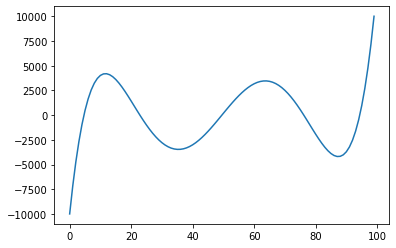

In [45]:
from matplotlib import pyplot as plt
plt.plot(np.polynomial.legendre.Legendre([1,1,5,0.1,0.2, 10000])(torch.linspace(-1,1,100)))

In [48]:
import numpy
a=np.array([2,2])
b=np.array([[1,1,1],[1,1,1]])
numpy.dot(a, b, out=None)

array([2, 2, 2])